### Tensorflow Seq2Seq model for translation from Swedish to English
___

In [18]:
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import time
import pickle as pl

# custom imports
from get_vocabulary import get_vocab
from encoder_decoder import Encoder, Decoder


print(f"tf=={tf.__version__}")
print(f"keras=={keras.__version__}")
print(f"np=={np.__version__}")
print(f"pd=={pd.__version__}")

tf==2.15.0
keras==2.15.0
np==1.26.2
pd==2.1.4


### Model data processing methods
___

In [19]:
MAX_LINES = 40_000  # to limit model training to some amount of lines


In [20]:
def create_dataset(src_file, tgt_file) -> tuple[np.ndarray[str]]:
    with open(file=src_file, mode="r", encoding="utf-8") as swef:
        swe_lines = [line[:-1] for line in swef.readlines()][:MAX_LINES]
    with open(file=tgt_file, mode="r", encoding="utf-8") as engf:
        eng_lines = [line[:-1] for line in engf.readlines()][:MAX_LINES]

    return swe_lines, eng_lines

#tokenize the sentence and pad the sequence to the same length
def tokenize(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

def load_dataset(src_file: str, tgt_file: str):
    swe_lines, eng_lines = create_dataset(src_file=src_file, tgt_file=tgt_file)

    input_tensor, inp_lang_tokenizer = tokenize(lang=swe_lines)
    target_tensor, targ_lang_tokenizer = tokenize(lang=eng_lines)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [21]:

local_dir_cleaned = "../../data/cleaned/"
clean_eng_file = "europarl-v6-cleaned-filtered.en"
clean_swe_file = "europarl-v6-cleaned-filtered.sv"

inp, tgt, inp_lang_tokenizer, tgt_lang_tokenizer = load_dataset(
    src_file=local_dir_cleaned+clean_swe_file, 
    tgt_file=local_dir_cleaned+clean_eng_file
)

with open(file="../../trained_model/src_lang_tokenizer.pkl", mode="wb") as f:
    pl.dump(inp_lang_tokenizer, f)
with open(file="../../trained_model/tgt_lang_tokenizer.pkl", mode="wb") as f:
    pl.dump(tgt_lang_tokenizer, f)

inp.shape, tgt.shape

((40000, 11), (40000, 11))

In [22]:
inp_train, inp_val, tgt_train, tgt_val = train_test_split(inp, tgt, test_size=0.2)
# inp_train, inp_val, tgt_train, tgt_val = train_test_split(inp_train_val, tgt_train_val, test_size=0.1)

print((inp_train.shape, tgt_train.shape))
print((inp_val.shape, tgt_val.shape))
# print((inp_test.shape, tgt_test.shape))

((32000, 11), (32000, 11))
((8000, 11), (8000, 11))


In [23]:
BUFFER_SIZE = inp_train.shape[0]
BATCH_SIZE = 64         # 64 sentences per batch
steps_per_epoch = inp_train.shape[0]//BATCH_SIZE
steps_per_epoch_val = inp_val.shape[0]//BATCH_SIZE
EMBEDDING_DIM = 256     # ... 
units = 1024    # dimensionality of output of RNN

inp_vocab = get_vocab(clean_file=local_dir_cleaned+clean_swe_file, max_lines=MAX_LINES)
tgt_vocab = get_vocab(clean_file=local_dir_cleaned+clean_eng_file, max_lines=MAX_LINES)

vocab_inp_size = len(inp_vocab)+1
vocab_tgt_size = len(tgt_vocab)+1

dataset = tf.data.Dataset.from_tensor_slices((inp_train, tgt_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
validation_dataset = tf.data.Dataset.from_tensor_slices((inp_val, tgt_val)).shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)

#### Samples
___

In [24]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 11]), TensorShape([64, 11]))

In [25]:
encoder = Encoder(vocab_inp_size, EMBEDDING_DIM, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

In [26]:
decoder = Decoder(vocab_tgt_size, EMBEDDING_DIM, units, BATCH_SIZE)

sample_decoder_output, _  = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 11405)


In [27]:
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real,pred):
    loss_ = loss_object(real,pred)
    return tf.reduce_mean(loss_)

In [28]:
print(loss_object([1,2],[[0,0.6,0.3,0.1],[0,0.6,0.3,0.1]]))

print(loss_function([1,2],[[0,0.6,0.3,0.1],[0,0.6,0.3,0.1]]))

tf.Tensor([1.063386  1.3633859], shape=(2,), dtype=float32)
tf.Tensor(1.2133859, shape=(), dtype=float32)


In [29]:
optimizer = keras.optimizers.legacy.Adam()


@tf.function
def train_step(inp, targ, enc_hidden, encoder, decoder):
    loss = 0

    with tf.GradientTape() as tape:
        _, enc_hidden = encoder(inp, enc_hidden)
    
        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([tgt_lang_tokenizer.word_index['<start>']]*BATCH_SIZE, 1)

        for t in range(1,targ.shape[1]):
            predictions, dec_hidden = decoder(dec_input, dec_hidden)     # enc_output , _
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:,t],1)
    
    batch_loss = (loss/int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


def calculate_validation_loss(inp, targ, enc_hidden, encoder, decoder):
    loss = 0
    _, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tgt_lang_tokenizer.word_index['<start>']]*BATCH_SIZE,1)

    for t in range(1, targ.shape[1]):
        predictions, dec_hidden = decoder(dec_input, dec_hidden)
        loss+=loss_function(targ[:,t], predictions)
        dec_input = tf.expand_dims(targ[:, t], 1)
    
    loss = loss/int(targ.shape[1])
    return loss



In [30]:
def training_seq2seq(epochs):
    encoder = Encoder(vocab_inp_size, EMBEDDING_DIM, units, BATCH_SIZE)
    decoder = Decoder(vocab_tgt_size, EMBEDDING_DIM, units, BATCH_SIZE)
    training_loss = []
    validation_loss = []

    for epoch in range(epochs):
        start = time.time()
        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0

        # NOTE PROBLEM
        for (batch,(inp,targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss = train_step(inp, targ, enc_hidden, encoder, decoder)
            total_loss+=batch_loss

            if batch%100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss))
        
        enc_hidden = encoder.initialize_hidden_state()
        total_val_loss = 0

        for (batch, (inp, targ)) in enumerate(validation_dataset.take(steps_per_epoch_val)):
            val_loss = calculate_validation_loss(inp, targ, enc_hidden, encoder, decoder)
            total_val_loss += val_loss
        
        training_loss.append(total_loss/steps_per_epoch)
        validation_loss.append(total_val_loss/steps_per_epoch_val)

        print('Epoch {} Loss {:.4f} Validation Loss {:.4f}'.format(epoch + 1, training_loss[-1], validation_loss[-1]))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    return encoder, decoder, training_loss, validation_loss

In [31]:
epochs = 7
attention = None
print("Running seq2seq model without attention")
encoder, decoder, training_loss, validation_loss = training_seq2seq(epochs)

tloss = training_loss
vloss = validation_loss

Running seq2seq model without attention
Epoch 1 Batch 0 Loss 8.4927
Epoch 1 Batch 100 Loss 3.8005
Epoch 1 Batch 200 Loss 3.7614
Epoch 1 Batch 300 Loss 3.2401
Epoch 1 Batch 400 Loss 3.1836
Epoch 1 Loss 3.5595 Validation Loss 2.9442
Time taken for 1 epoch 250.5608491897583 sec

Epoch 2 Batch 0 Loss 2.7292
Epoch 2 Batch 100 Loss 2.6592
Epoch 2 Batch 200 Loss 2.5869
Epoch 2 Batch 300 Loss 2.5329
Epoch 2 Batch 400 Loss 2.6176
Epoch 2 Loss 2.6051 Validation Loss 2.5653
Time taken for 1 epoch 261.6411430835724 sec

Epoch 3 Batch 0 Loss 2.0865
Epoch 3 Batch 100 Loss 2.0149
Epoch 3 Batch 200 Loss 2.0016
Epoch 3 Batch 300 Loss 2.0107
Epoch 3 Batch 400 Loss 1.9418
Epoch 3 Loss 2.0814 Validation Loss 2.4002
Time taken for 1 epoch 256.5561611652374 sec

Epoch 4 Batch 0 Loss 1.5841
Epoch 4 Batch 100 Loss 1.6207
Epoch 4 Batch 200 Loss 1.4684
Epoch 4 Batch 300 Loss 1.7981
Epoch 4 Batch 400 Loss 1.7275
Epoch 4 Loss 1.6292 Validation Loss 2.3686
Time taken for 1 epoch 298.64318895339966 sec

Epoch 5 Bat

In [32]:
encoder_save_path = "../../trained_model/seq2seq-trained-encoder"
decoder_save_path = "../../trained_model/seq2seq-trained-decoder"
encoder.save(filepath=encoder_save_path)
decoder.save(filepath=decoder_save_path)

INFO:tensorflow:Assets written to: ../../trained_model/seq2seq-trained-encoder/assets


INFO:tensorflow:Assets written to: ../../trained_model/seq2seq-trained-encoder/assets


INFO:tensorflow:Assets written to: ../../trained_model/seq2seq-trained-decoder/assets


INFO:tensorflow:Assets written to: ../../trained_model/seq2seq-trained-decoder/assets


In [33]:
vloss = [float(loss) for loss in vloss]
tloss = [float(loss) for loss in tloss]

Text(0.5, 0, 'No. training iterations on dataset [Epochs]')

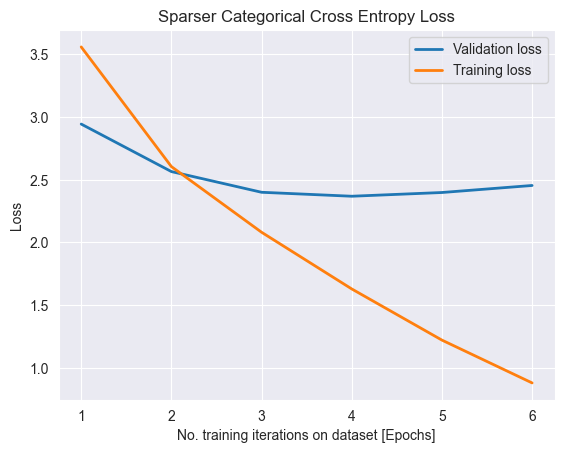

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

ax = plt.subplot(111) 
t = np.arange(1, epochs+1)

for i in range(0, len(vloss)):
  ax.cla()
  line1, = plt.plot(t[:i], vloss[:i], lw=2)
  line2, = plt.plot(t[:i], tloss[:i], lw=2)

ax.legend(["Validation loss", "Training loss"])
ax.set_title("Sparser Categorical Cross Entropy Loss")
ax.set_ylabel("Loss")
ax.set_xlabel("No. training iterations on dataset [Epochs]")



In [35]:
vloss[-1], tloss[-1]

(2.53334641456604, 0.6146905422210693)

In [51]:
def translate(sentence: str, encoder, decoder):
    # attention_plot = np.zeros((max_length_targ, max_length_inp))
    # sentence = preprocess_sentence(sentence)

    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=inp.shape[1], padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1,units))]
    _, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([tgt_lang_tokenizer.word_index['<start>']], 0)

    for t in range(inp.shape[1]):
        predictions, dec_hidden = decoder(dec_input, dec_hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        if tgt_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, " ".join(w for w in sentence.split(" ")[1:-1])
        result += tgt_lang_tokenizer.index_word[predicted_id] + ' '

        
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, " ".join(w for w in sentence.split(" ")[1:-1])

In [55]:
swedish_sentence = "debatten forklarar jag avslutad ."

result, sentence = translate(u"<start> " + swedish_sentence + " <end>", encoder, decoder)
print(f'Input sentence  : {sentence}')
print(f'Translation     : {result}')

Input sentence  : debatten forklarar jag avslutad .
Translation     : that concludes the vote . 
